# HMDA Data Testing

## TODO:
### Data Collection

### Data Cleaning
- [ ] merge like columns together, ex: 'denial_reason-1', 'denial_reason-2', 'denial_reason-3',
       'denial_reason-4'
- [X] fix interest rate column
- [X] fix loan term column

### Statistics
- [x] summary statistics table: interest_rate by race
- [x] ANOVA test: interest_rate by race

### Documentation
- [ ] data exploration and cleanup process
- [ ] other data (show the download, df load, and df) and how poor it was
- [ ] API fixes - was downloading nationwide, and it was too big for jupyterlab/pandas/computer
- [ ] print example, found problem with 'state'.value_counts()
- [ ] data exploration - print columns, print value_counts for each
- [ ] data exploration - pull out a DF and show it of just the primary columns

## Setup
-----

In [1]:
import gzip
import os
import requests
import subprocess
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.stats as stats

# supporting code
from hmda_lib import valid_state_codes
from hmda_lib import valid_years

# data visualizations
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def download_hmda_data(fd, state, year):
    url = f'https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?states={state}&years={year}'

    try:
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(output_file, 'wb') as fd:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        fd.write(chunk)
        return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
        return False

In [3]:
def compress_hmda_data(f):
    subprocess.run(['gzip', f])    

## Data Collection
-----

In [4]:
# download HMDA data from API

state = 'MN'
years = ['2018', '2019', '2020', '2021', '2022']

for year in years:
    output_file = Path('hmda_data', f'hmda-{state}-{year}.csv')
    if os.path.exists(f'{output_file}.gz'):
        print('File exists already! Skipping!')
        continue
    else:
        print(f'Downloading HMDA data for: {year} {state}.....', end='')
        download_hmda_data(output_file, state, year)
        print(' compressing.....', end='')
        compress_hmda_data(output_file)
        print(' done!')

File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!
File exists already! Skipping!


In [5]:
# load the HMDA data into Pandas DataFrames

data_path = 'hmda_data'
filenames = os.listdir(data_path)
all_dataframes = []

for filename in filenames:
    if filename.endswith('.csv.gz'):
        filepath = Path(data_path, filename)
        with gzip.open(filepath, 'rt') as file:
            df = pd.read_csv(filepath)
        all_dataframes.append(df)

unclean_df = pd.concat(all_dataframes, ignore_index=True)

/tmp/ipykernel_128258/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_128258/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_128258/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_128258/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/tmp/ipykernel_128258/2038427819.py:11: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set lo

## Data Cleaning
-----

In [6]:
# remove null values and 'Exempt' interest rate from dataframe

df = unclean_df[unclean_df['interest_rate'].notnull()]
df = df.query('interest_rate != "Exempt"')
df = df.query('loan_to_value_ratio != "Exempt"')

In [7]:
# remove null loan terms from dataframe

df = df[df['loan_term'].notnull()]

In [8]:
# data type conversions

df['interest_rate'] = pd.to_numeric(df['interest_rate'], errors='raise')
df['loan_to_value_ratio'] = pd.to_numeric(df['loan_to_value_ratio'], errors='raise')

In [9]:
# rename values

df['derived_race'] = df['derived_race'].replace({
    'Black or African American': 'Black',
    'American Indian or Alaska Native': 'Native',
    'Native Hawaiian or Other Pacific Islander': 'Pacific Islander'
})

In [34]:
# drop lending institutions that have low application counts

df['lei'].value_counts()

lei
6BYL5QZYBDK8S7L73M02    117008
KB1H1DSPRFMYMCUFXT09     90161
549300WYBPIWKK6SQC06     56778
549300FGXN1K3HLB1R50     55076
549300HW662MN1WU8550     33033
                         ...  
5493008ICL5D7TS4CI35         1
549300AX5UMUZ61L1X54         1
5493003H8ECZKN77IZ88         1
549300UL36AJZ0WZ4U93         1
549300214PKB2Y1ZWH75         1
Name: count, Length: 1018, dtype: int64

## Data Exploration
-----

In [10]:
df['county_code'].value_counts()

county_code
27053.0    311846
27037.0    121816
27123.0    106889
27003.0    103154
27163.0     81346
            ...  
55113.0         1
29095.0         1
46099.0         1
38017.0         1
6037.0          1
Name: count, Length: 111, dtype: int64

In [11]:
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
1,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27123.0,2.712304e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4366,38.91,97300,71,750,878,50
2,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27053.0,2.705303e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3248,8.68,97300,138,1147,1246,49
3,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27163.0,2.716307e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3995,9.31,97300,103,1367,1741,38
4,2020,AD6GFRVSDT01YPT1CS68,99999,MN,27035.0,2.703595e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,1910,1.20,70900,90,843,2542,33
5,2020,AD6GFRVSDT01YPT1CS68,33460,MN,27139.0,2.713908e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7709,20.08,97300,158,2415,2818,13


In [12]:
for c in df.columns:
    print(c)

activity_year
lei
derived_msa-md
state_code
county_code
census_tract
conforming_loan_limit
derived_loan_product_type
derived_dwelling_category
derived_ethnicity
derived_race
derived_sex
action_taken
purchaser_type
preapproval
loan_type
loan_purpose
lien_status
reverse_mortgage
open-end_line_of_credit
business_or_commercial_purpose
loan_amount
loan_to_value_ratio
interest_rate
rate_spread
hoepa_status
total_loan_costs
total_points_and_fees
origination_charges
discount_points
lender_credits
loan_term
prepayment_penalty_term
intro_rate_period
negative_amortization
interest_only_payment
balloon_payment
other_nonamortizing_features
property_value
construction_method
occupancy_type
manufactured_home_secured_property_type
manufactured_home_land_property_interest
total_units
multifamily_affordable_units
income
debt_to_income_ratio
applicant_credit_score_type
co-applicant_credit_score_type
applicant_ethnicity-1
applicant_ethnicity-2
applicant_ethnicity-3
applicant_ethnicity-4
applicant_ethnicit

In [13]:
for c in df.columns:
    print(f'Examining column: {c}')
    print(df[c].value_counts())
    print()

Examining column: activity_year
activity_year
2020    352175
2021    340417
2019    226539
2018    188313
2022    171579
Name: count, dtype: int64

Examining column: lei
lei
6BYL5QZYBDK8S7L73M02    117008
KB1H1DSPRFMYMCUFXT09     90161
549300WYBPIWKK6SQC06     56778
549300FGXN1K3HLB1R50     55076
549300HW662MN1WU8550     33033
                         ...  
5493008ICL5D7TS4CI35         1
549300AX5UMUZ61L1X54         1
5493003H8ECZKN77IZ88         1
549300UL36AJZ0WZ4U93         1
549300214PKB2Y1ZWH75         1
Name: count, Length: 1018, dtype: int64

Examining column: derived_msa-md
derived_msa-md
33460    922913
99999    194118
40340     46655
20260     40437
41060     37052
22020     14455
31860     13873
24220      4538
29100      3301
0          1662
38060         3
36084         2
32580         1
36100         1
39580         1
38940         1
19740         1
23580         1
12980         1
47300         1
36740         1
16974         1
41700         1
28140         1
43620       

In [14]:
df['derived_race'].value_counts()

derived_race
White                       882643
Race Not Available          288832
Asian                        47390
Black                        30486
Joint                        23764
Native                        3857
Pacific Islander              1106
2 or more minority races       879
Free Form Text Only             66
Name: count, dtype: int64

## Statistics Summaries
-----

In [15]:
# Statistics Summary Table - Interest Rates by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Interest Rate": race_group['interest_rate'].mean(),
    "Median Interest Rate": race_group['interest_rate'].median(),
    "Interest Rate Variance": race_group['interest_rate'].var(),
    "Interest Rate Std. Dev.": race_group['interest_rate'].std(),
    "Interest Rate Std. Err.": race_group['interest_rate'].sem()
})

summary_table

,Mean Interest Rate,Median Interest Rate,Interest Rate Variance,Interest Rate Std. Dev.,Interest Rate Std. Err.
derived_race,,,,,
2 or more minority races,3.947778,3.625,2.205659,1.485146,0.050093
Asian,3.687475,3.375,1.426056,1.194176,0.005486
Black,3.820617,3.500,10.695898,3.270458,0.018731
Free Form Text Only,4.121212,3.750,2.153253,1.467397,0.180624
Joint,3.803048,3.500,1.382663,1.175867,0.007628
Native,3.943490,3.625,2.024991,1.423022,0.022913
Pacific Islander,3.903947,3.625,1.771620,1.331022,0.040023
Race Not Available,4.013744,3.625,425.640704,20.631062,0.038388
White,3.788169,3.500,63.506752,7.969112,0.008482


In [16]:
# Statistics Summary Table - Loan Amount by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Loan Amount": race_group['loan_amount'].mean(),
    "Median Loan Amount": race_group['loan_amount'].median(),
    "Loan Amount Variance": race_group['loan_amount'].var(),
    "Loan Amount Std. Dev.": race_group['loan_amount'].std(),
    "Loan Amount Std. Err.": race_group['loan_amount'].sem()
})

summary_table

,Mean Loan Amount,Median Loan Amount,Loan Amount Variance,Loan Amount Std. Dev.,Loan Amount Std. Err.
derived_race,,,,,
2 or more minority races,222792.946530,215000.0,1.509763e+10,1.228724e+05,4144.383518
Asian,259132.306394,245000.0,2.159910e+10,1.469663e+05,675.109934
Black,233876.533491,225000.0,1.672560e+10,1.293275e+05,740.697008
Free Form Text Only,177121.212121,160000.0,1.914005e+10,1.383476e+05,17029.407105
Joint,263156.455142,245000.0,3.046722e+10,1.745486e+05,1132.287305
Native,202814.363495,185000.0,1.710770e+10,1.307964e+05,2106.060973
Pacific Islander,188860.759494,165000.0,1.275095e+11,3.570847e+05,10737.266542
Race Not Available,299401.347496,225000.0,1.590348e+12,1.261090e+06,2346.515169
White,231484.173103,205000.0,2.525568e+10,1.589203e+05,169.155828


In [17]:
# Statistics Summary Table - loan_to_value_ratio by Race
race_group = df.groupby('derived_race')

summary_table = pd.DataFrame({
    "Mean Loan to Value Ratio": race_group['loan_to_value_ratio'].mean(),
    "Median Loan to Value Ratio": race_group['loan_to_value_ratio'].median(),
    "Loan to Value Ratio Variance": race_group['loan_to_value_ratio'].var(),
    "Loan to Value Ratio Std. Dev.": race_group['loan_to_value_ratio'].std(),
    "Loan to Value Ratio Std. Err.": race_group['loan_to_value_ratio'].sem()
})

summary_table

,Mean Loan to Value Ratio,Median Loan to Value Ratio,Loan to Value Ratio Variance,Loan to Value Ratio Std. Dev.,Loan to Value Ratio Std. Err.
derived_race,,,,,
2 or more minority races,83.870818,90.0000,3.262467e+02,18.062301,0.639399
Asian,78.711334,80.0000,3.321952e+02,18.226223,0.087076
Black,84.992076,90.0010,3.088362e+02,17.573736,0.105730
Free Form Text Only,74.098766,79.6150,4.812053e+02,21.936393,2.742049
Joint,77.881710,80.0000,3.260366e+02,18.056485,0.121906
Native,80.468634,81.8750,3.725801e+02,19.302335,0.328339
Pacific Islander,76.671769,79.9615,4.062736e+02,20.156230,0.634233
Race Not Available,73.672802,77.0000,3.634651e+02,19.064760,0.053932
White,99.269989,79.7640,4.009625e+08,20024.049157,22.232933


In [35]:
# Statistics Summary Table - interest_rate by lending institute
lei_group = df.groupby('lei')

summary_table = pd.DataFrame({
    "Mean Interest Rate": lei_group['interest_rate'].mean(),
    "Median Interest Rate": lei_group['interest_rate'].median(),
    "Interest Rate Variance": lei_group['interest_rate'].var(),
    "Interest Rate Std. Dev.": lei_group['interest_rate'].std(),
    "Interest Rate Std. Err.": lei_group['interest_rate'].sem()
})

summary_table

,Mean Interest Rate,Median Interest Rate,Interest Rate Variance,Interest Rate Std. Dev.,Interest Rate Std. Err.
lei,,,,,
0K2D5AK28E3O5CC06E35,3.171875,3.1250,0.355990,0.596649,0.149162
0L0W72STJN2EGP1X2N39,4.733742,4.7500,0.749633,0.865813,0.027872
0S8H5NJFLHEVJXVTQ413,3.375000,3.3750,0.031250,0.176777,0.125000
1DU7IM20QESYGDO4HO54,3.792500,4.3200,2.779692,1.667241,0.833620
1IE8VN30JCEQV1H4R804,3.630800,3.5760,0.761900,0.872869,0.195179
...,...,...,...,...,...
YJMYTIGWK1HM7EQ06C15,4.230441,4.1875,0.182554,0.427263,0.073275
YQI2CPR3Z44KAR0HG822,3.325000,2.8750,1.098438,1.048064,0.468708
YWC0TIKBQM2JV8L4IV08,2.400000,2.5000,0.167500,0.409268,0.236291


## Hypothesis Testing
-----

### ANOVA Tests

In [18]:
# Extract individual groups
group0 = df[df["derived_race"].str.fullmatch('White')]["interest_rate"]
group1 = df[df["derived_race"].str.fullmatch('Race Not Available')]["interest_rate"]
group2 = df[df["derived_race"].str.fullmatch('Asian')]["interest_rate"]
group3 = df[df["derived_race"].str.fullmatch('Joint')]["interest_rate"]
group4 = df[df["derived_race"].str.fullmatch('Black')]["interest_rate"]
group5 = df[df["derived_race"].str.fullmatch('Native')]["interest_rate"]
group6 = df[df["derived_race"].str.fullmatch('2 or more minority races')]["interest_rate"]
group7 = df[df["derived_race"].str.fullmatch('Pacific Islander')]["interest_rate"]
group8 = df[df["derived_race"].str.fullmatch('Free Form Text Only')]["interest_rate"]

# Perform the ANOVA test
stats.f_oneway(group0, group1, group2, group3, group4, group5, group6, group7, group8)

F_onewayResult(statistic=10.948260161132048, pvalue=1.4375699707682176e-15)

#### Interpretation
A p-value of 1.4375699707682176e-15 (approximately 1.44 x 10^-15) is extremely small. In the context of statistical hypothesis testing, this indicates:

Strong Evidence Against the Null Hypothesis: The observed results are highly unlikely to have occurred by random chance alone if the null hypothesis (the assumption of no effect or no difference) were true.
Statistical Significance: The result is highly statistically significant. This means you can confidently reject the null hypothesis and conclude that there is a significant effect or difference present in your data.

Source: Google Gemini

## Visualizations
-----

### Bar Graphs

In [19]:
df['interest_rate'] = df['interest_rate'].astype(float)
df['interest_rate'].value_counts().hvplot.bar(
    title='Bar Graph for interest_rate',
    xlabel='interest_rate',
    ylabel='Population [100,000]',
    rot=90,
    width=1000,
    height=600
)

:Bars   [interest_rate]   (count)

In [20]:
df['derived_ethnicity'].value_counts().hvplot.bar(
    title='Bar Graph for derived_ethnicity',
    xlabel='Ethnicity',
    ylabel='Population [100,000]',
    rot=90,
    width=600,  # Set the width of the plot
    height=400  # Set the height of the plot
)

:Bars   [derived_ethnicity]   (count)

In [21]:
df['derived_race'].value_counts().hvplot.bar(
    title='Bar Graph for derived_race',
    xlabel='Race',
    ylabel='Population [100,000]',
    rot=90,
    width=800,  # Set the width of the plot
    height=400  # Set the height of the plot
)

:Bars   [derived_race]   (count)

In [23]:
df['derived_sex'].value_counts().hvplot.bar(
    title='Bar Graph for derived_sex',
    xlabel='Sex of head of house',
    ylabel='Population [100,000]',
    rot=90,
    width=600,
    height=300
)

:Bars   [derived_sex]   (count)

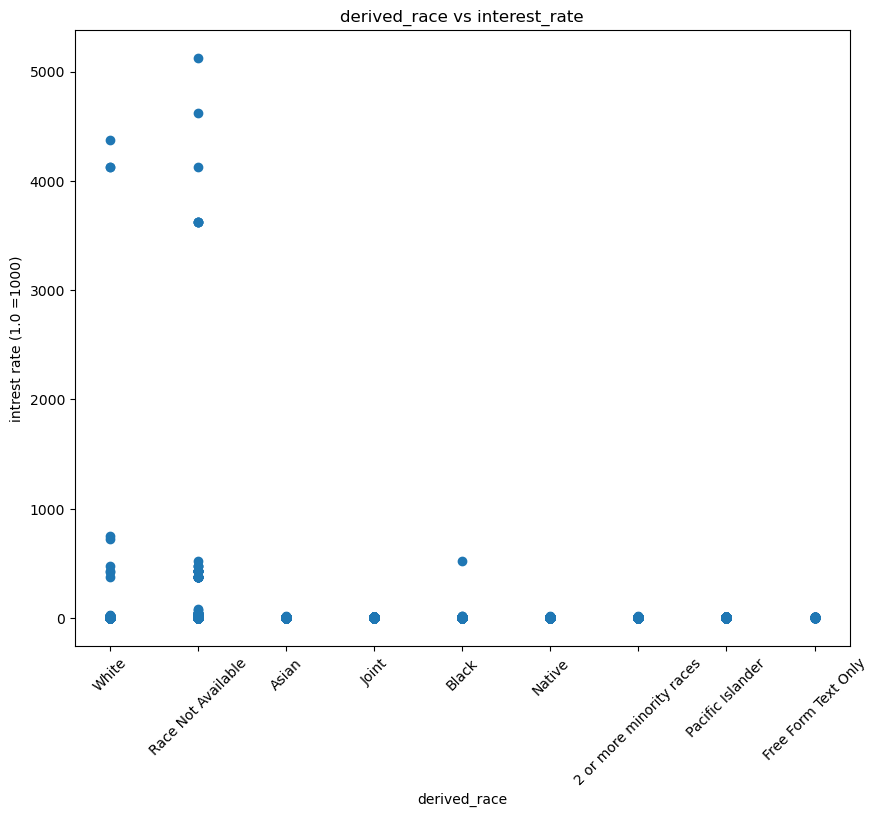

In [24]:
#Brivate and Correlation
plt.figure(figsize=(10, 8))
plt.scatter(df['derived_race'], df['interest_rate'])
plt.title('derived_race vs interest_rate')
plt.xlabel('derived_race')
plt.ylabel('intrest rate (1.0 =1000)')
plt.xticks(rotation=45)  # Rotate the x-label by 45 degrees
plt.show()

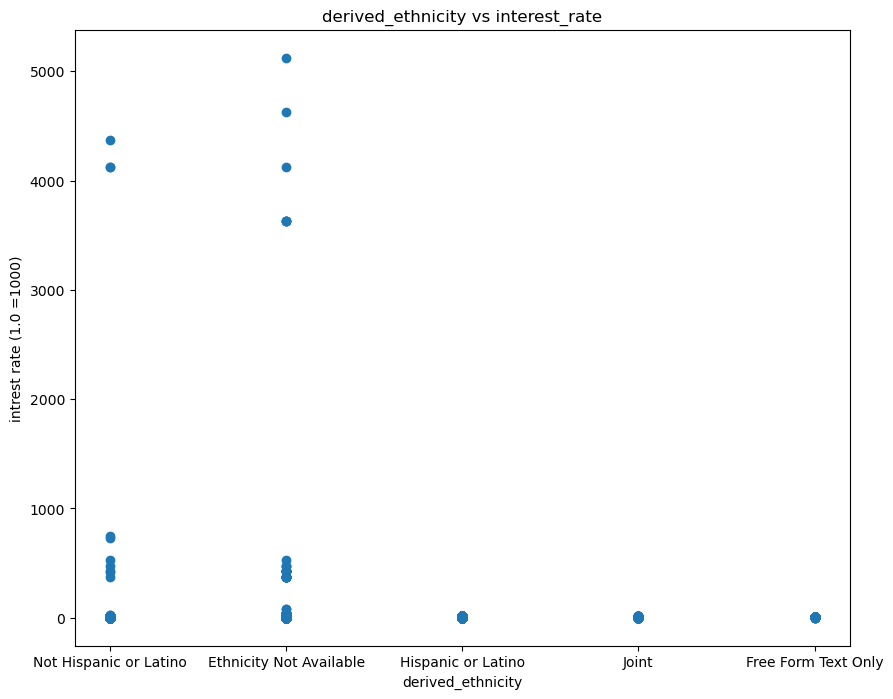

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(df['derived_ethnicity'], df['interest_rate'])
plt.title('derived_ethnicity vs interest_rate')
plt.xlabel('derived_ethnicity')
plt.ylabel('intrest rate (1.0 =1000)')
plt.show()

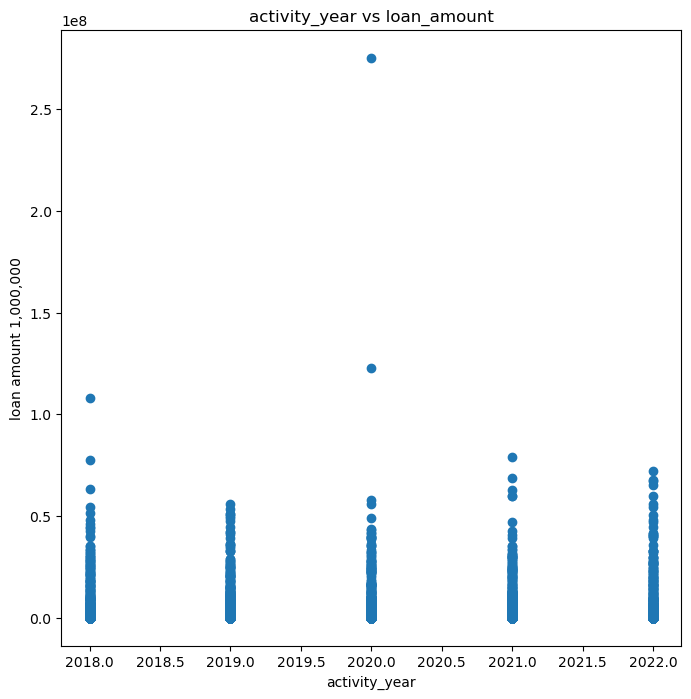

Correlation between intrest_rate and tract_population: 0.025783631753125962


In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(df['activity_year'], df['loan_amount'])
plt.title('activity_year vs loan_amount')
plt.xlabel('activity_year')
plt.ylabel('loan amount 1,000,000')
plt.show()

# Calculate correlation
correlation = df['loan_amount'].corr(df['activity_year'])
print(f"Correlation between intrest_rate and tract_population: {correlation}")
plt.show()

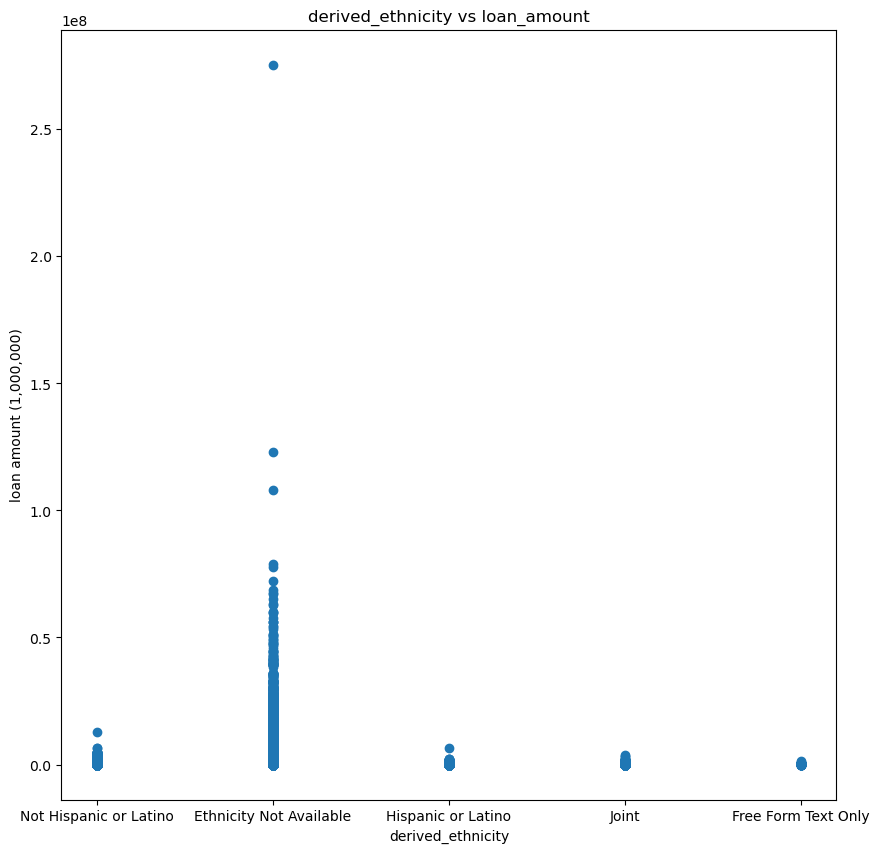

In [27]:
plt.figure(figsize=(10, 10))
plt.scatter(df['derived_ethnicity'], df['loan_amount'])
plt.title('derived_ethnicity vs loan_amount')
plt.xlabel('derived_ethnicity')
plt.ylabel('loan amount (1,000,000)')
plt.show()

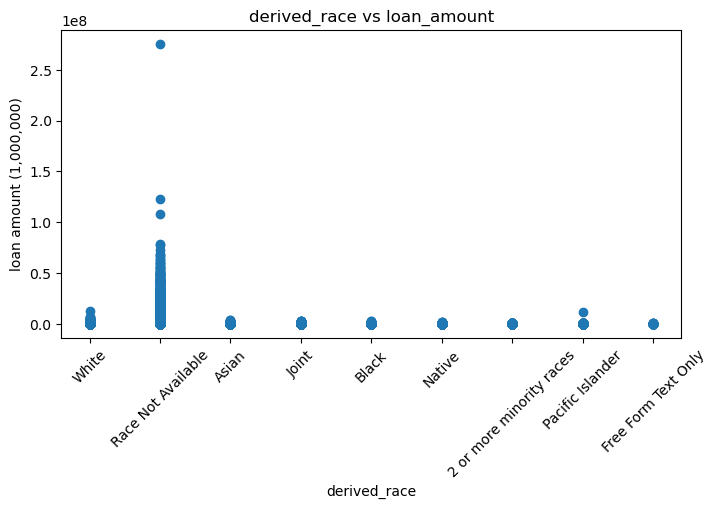

In [28]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_race'], df['loan_amount'])
plt.title('derived_race vs loan_amount')
plt.xlabel('derived_race')
plt.ylabel('loan amount (1,000,000)')
plt.xticks(rotation=45)
plt.show()

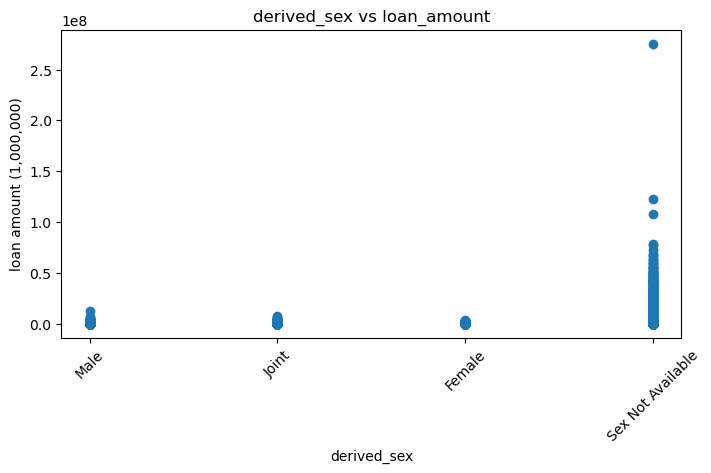

In [29]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_sex'], df['loan_amount'])
plt.title('derived_sex vs loan_amount')
plt.xlabel('derived_sex')
plt.ylabel('loan amount (1,000,000)')
plt.xticks(rotation=45)
plt.show()

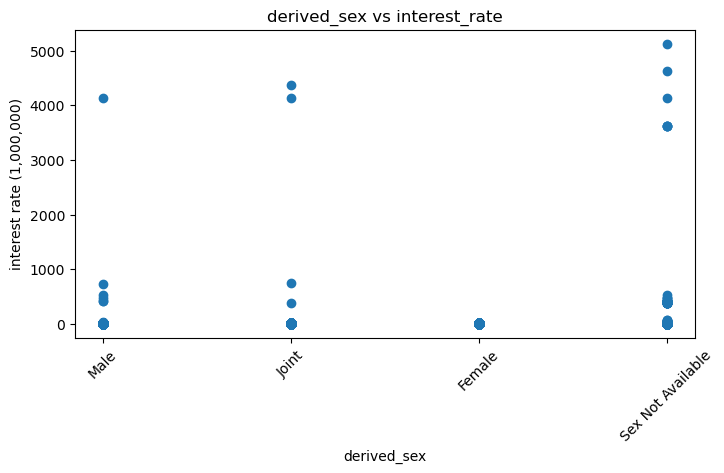

In [30]:
plt.figure(figsize=(8, 4))
plt.scatter(df['derived_sex'], df['interest_rate'])
plt.title('derived_sex vs interest_rate')
plt.xlabel('derived_sex')
plt.ylabel('interest rate (1,000,000)')
plt.xticks(rotation=45)
plt.show()

## Exploring Mortgage Demographics and Interest Rates      

In our analysis of mortgage data, we focused on interest rates and demographic characteristics. Here are the key findings:

## Interest Rates Distribution:

The majority of interest rates fall within the range of 0% to 8%.

This distribution provides an overview of the prevailing interest rate landscape.

## Demographic Breakdown:

White mortgage owners constitute the largest group, with a total of 882,643 individuals.

Other racial groups follow, but none come close to the White population in terms of mortgage ownership.

## Ownership Types and Interest Rates:

Joint ownership is the most common form of mortgage ownership, with 498,530 cases.

Interestingly, joint owners tend to have higher interest rates compared to other ownership types.

Female mortgage owners are the least represented group, with 220,124 individuals.

## Interest Rate Peaks:

Among all racial groups, Whites exhibit the highest peaks in interest rates.

Further investigation into the factors driving these differences would be valuable.

-----